In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import gc

# Load Data

In [2]:
questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [3]:
lectures = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [4]:
example_test = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')
example_test.head()

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN


In [5]:
example_sample_submission = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv')
example_sample_submission.head()

,row_id,answered_correctly,group_num
0,0,0.5,0
1,1,0.5,0
2,2,0.5,0
3,3,0.5,0
4,4,0.5,0


In [6]:
%%time

train = pd.read_pickle("/kaggle/input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip")

print("Train size:", train.shape)

Train size: (101230332, 10)
CPU times: user 4.1 s, sys: 5.03 s, total: 9.13 s
Wall time: 34.4 s


In [7]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,None
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 bool   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  object 
dtypes: bool(1), float32(1), int16(2), int32(1), int64(2), int8(2), object(1)
memory usage: 3.7+ GB


In [9]:
train.memory_usage(deep=True)

Index                                    128
row_id                             809842656
timestamp                          809842656
user_id                            404921328
content_id                         202460664
content_type_id                    101230332
task_container_id                  202460664
user_answer                        101230332
answered_correctly                 101230332
prior_question_elapsed_time        404921328
prior_question_had_explanation    3594972816
dtype: int64

In [10]:
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('bool')
train.memory_usage(deep=True)

Index                                   128
row_id                            809842656
timestamp                         809842656
user_id                           404921328
content_id                        202460664
content_type_id                   101230332
task_container_id                 202460664
user_answer                       101230332
answered_correctly                101230332
prior_question_elapsed_time       404921328
prior_question_had_explanation    101230332
dtype: int64

# EDA

## Train

In [11]:
# helper functions
def null_percent(df):
    """
    Takes a dataframe and returns missing data count and percentage of each column.
    """
    null_count = df.isnull().sum().sort_values(ascending=False)
    null_percent = (df.isnull().sum()/df.shape[0]).apply(lambda x: format(x,'.2%'))
    return pd.concat([null_count, null_percent], axis=1, keys=['count', 'percent'])


def value_counts(Series):
    """
    Takes a categorical feature column, return value count and percentage.
    """
    count = Series.value_counts(dropna=False)
    percent = Series.value_counts(dropna=False, normalize=True).apply(lambda x: format(x, '.2%'))
    
    
    return pd.concat([count, percent], axis=1, keys=['count', 'percent'])

In [12]:
null_percent(train)

,count,percent
prior_question_elapsed_time,2351538,2.32%
prior_question_had_explanation,0,0.00%
answered_correctly,0,0.00%
user_answer,0,0.00%
task_container_id,0,0.00%
content_type_id,0,0.00%
content_id,0,0.00%
user_id,0,0.00%
timestamp,0,0.00%
row_id,0,0.00%


### Target - Answered Correctly

In [13]:
value_counts(train['answered_correctly'])

,count,percent
1,65244627,64.45%
0,34026673,33.61%
-1,1959032,1.94%


### Users

In [14]:
# unique users
train['user_id'].nunique()

393656

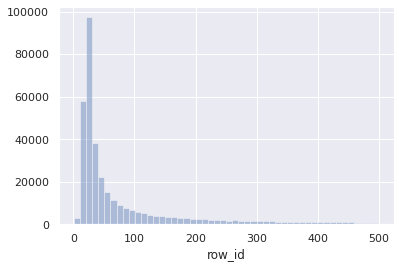

In [15]:
user_id_row_cnts = train.groupby('user_id').count()['row_id']
sns.distplot(user_id_row_cnts[user_id_row_cnts < 500], kde=False)
plt.show()

### Content

In [16]:
# content
print('unique content_id: ',train['content_id'].nunique())
print('unique content_id of questions: ', train['content_id'][train['content_type_id']==False].nunique())
print(train['content_id'][train['content_type_id']==False].nunique()/train['content_id'].nunique())

unique content_id:  13782
unique content_id of questions:  13523
0.9812073719344072


In [17]:
value_counts(train['content_type_id'])

,count,percent
False,99271300,98.06%
True,1959032,1.94%


In [18]:
df = pd.DataFrame(train['content_id'].value_counts()[:50]).reset_index()
df.columns = ['content_id', 'count']
df.head()

,content_id,count
0,6116,213605
1,6173,202106
2,4120,199372
3,175,195861
4,7876,190170


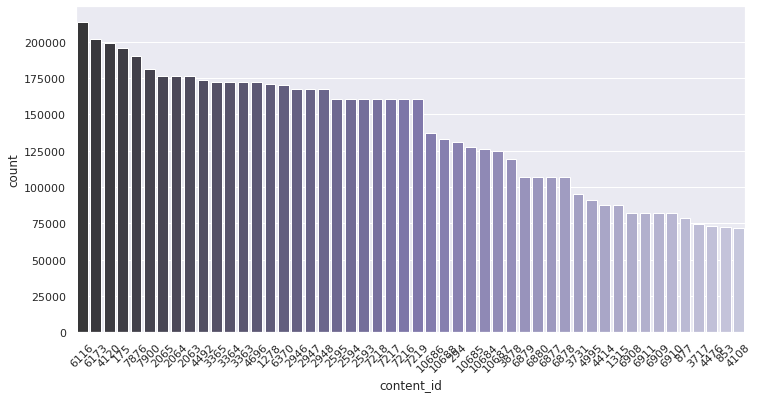

In [19]:
plt.figure(figsize=(12,6))
sns.barplot(x='content_id', y='count', data=df, order=df['content_id'], palette='Purples_d')
plt.xticks(rotation=45)
plt.show()

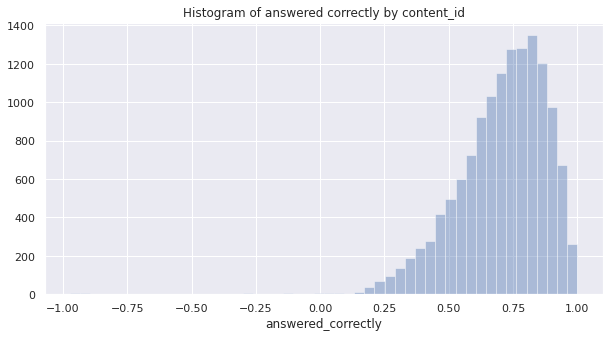

In [20]:
df = train.groupby('content_id').mean()['answered_correctly']

plt.figure(figsize=(10,5))
sns.distplot(df[df!=-1], kde=False)
plt.title('Histogram of answered correctly by content_id')
plt.show()

### Task container (batch of questions/lectures)

In [21]:
train['task_container_id'].nunique()

10000

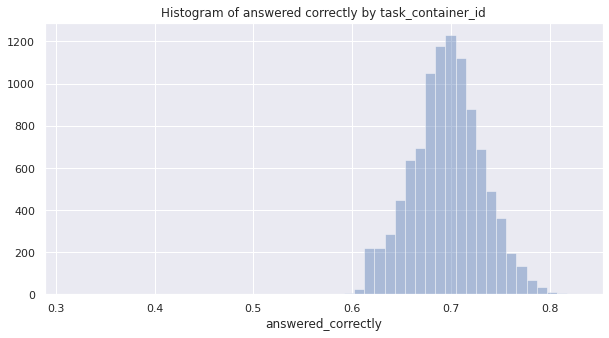

In [22]:
df = train.groupby('task_container_id').mean()['answered_correctly']

plt.figure(figsize=(10,5))
sns.distplot(df[df!=-1], kde=False)
plt.title('Histogram of answered correctly by task_container_id')
plt.show()

### Answer
1959032 no answers, those are lectures

In [23]:
train['user_answer'].value_counts()

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

### Prior questions
is null for a user's first question bundle or lecture

In [24]:
value_counts(train['prior_question_had_explanation'])

,count,percent
True,89685560,88.60%
False,11544772,11.40%


In [25]:
train[train['answered_correctly']!=-1].groupby('answered_correctly').mean()['prior_question_had_explanation']

answered_correctly
0    0.861391
1    0.925368
Name: prior_question_had_explanation, dtype: float64

In [26]:
del df
gc.collect()

28901

### Timestamp

In [27]:
ts = train['timestamp']/(31536000000/12)

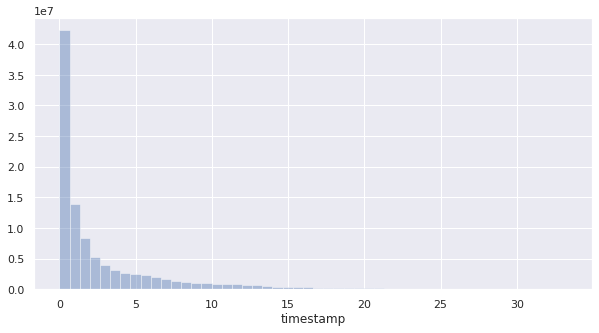

In [28]:
plt.figure(figsize=(10,5))
sns.distplot(ts, kde=False)
plt.show()

In [29]:
print('unique users: ', train['user_id'].nunique())
print('unique users with timestamp 0: ', train['user_id'][train['timestamp']==0].nunique())

unique users:  393656
unique users with timestamp 0:  393656


## Questions

In [30]:
questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [31]:
questions.isnull().sum()

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

### question_id & bundle_id

In [32]:
questions.iloc[1400:1420,:]

,question_id,bundle_id,correct_answer,part,tags
1400,1400,1400,0,3,74 92 102
1401,1401,1400,0,3,136 92 102
1402,1402,1400,1,3,82 92 102
1403,1403,1403,1,3,106 38 29
1404,1404,1403,0,3,136 38 29
1405,1405,1403,3,3,82 38 29
1406,1406,1406,2,3,106 38 102
1407,1407,1406,3,3,136 38 102
1408,1408,1406,2,3,157 38 102
1409,1409,1409,3,3,82 92 29


In [33]:
print(questions.shape)
print(questions['question_id'].nunique())
print(questions['bundle_id'].nunique())

(13523, 5)
13523
9765


### part

In [34]:
questions['part'].value_counts()

5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
Name: part, dtype: int64

In [35]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,False
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


In [36]:
# part distribution in all interactions
question_cnt = train[train['content_type_id']==False].groupby('content_id', as_index=False).count()[['content_id','row_id']]
question_cnt.columns = ['question_id', 'cnt']
question_cnt.head()

,question_id,cnt
0,0,6903
1,1,7398
2,2,44905
3,3,22973
4,4,31736


,part,cnt
0,1,7454570
1,2,18743404
2,3,8639907
3,4,8067676
4,5,40908153
5,6,10501472
6,7,4956118


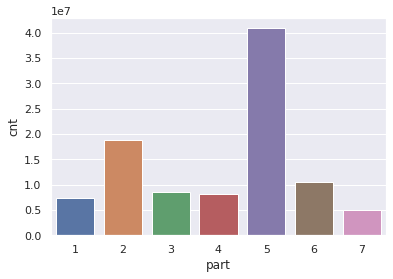

In [37]:
part_cnt = pd.merge(question_cnt, questions, on='question_id', how='left').\
groupby('part', as_index=False).sum()[['part', 'cnt']]

display(part_cnt)

sns.barplot(x='part', y='cnt', data=part_cnt)
plt.show()

In [38]:
del question_cnt
gc.collect()

9165

In [39]:
del part_cnt
gc.collect()

20

In [40]:
question_right_wrong = train[train['content_type_id']==False].\
groupby('content_id', as_index=False).agg({'answered_correctly':['count', 'sum']})

question_right_wrong.columns = ['question_id', 'all', 'right']
question_right_wrong['right'] = question_right_wrong['right'].astype('int')
question_right_wrong['correct_percent'] = question_right_wrong['right']/question_right_wrong['all']
question_right_wrong

,question_id,all,right,correct_percent
0,0,6903,6266,0.907721
1,1,7398,6589,0.890646
2,2,44905,24890,0.554281
3,3,22973,17906,0.779437
4,4,31736,19461,0.613215
...,...,...,...,...
13518,13518,868,683,0.786866
13519,13519,924,528,0.571429
13520,13520,861,579,0.672474
13521,13521,870,703,0.808046


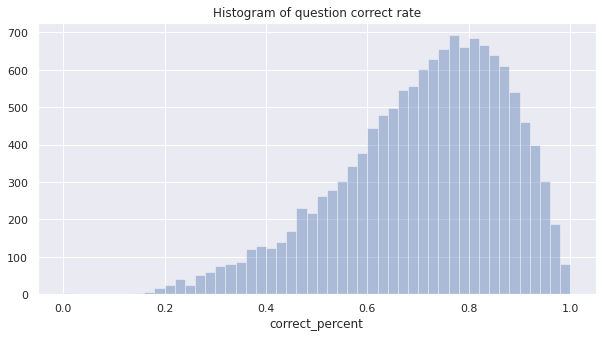

In [41]:
plt.figure(figsize=(10,5))
sns.distplot(question_right_wrong['correct_percent'], kde=False)
plt.title('Histogram of question correct rate')
plt.show()

,part,all,right,correct_percent
0,1,7454570,5553896,0.745032
1,2,18743404,13283339,0.708694
2,3,8639907,6060514,0.701456
3,4,8067676,5090684,0.630998
4,5,40908153,24957570,0.610088
5,6,10501472,7029563,0.669388
6,7,4956118,3269061,0.659601


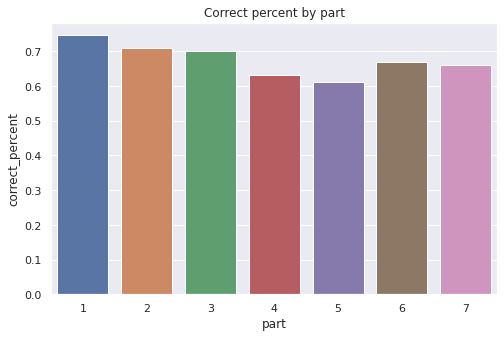

In [42]:
part_correct_percent = \
pd.merge(question_right_wrong[['question_id', 'all', 'right']], questions, on='question_id', how='left')\
.groupby('part', as_index=False).sum()[['part', 'all', 'right']]
part_correct_percent['correct_percent'] = part_correct_percent['right']/part_correct_percent['all']
display(part_correct_percent)

plt.figure(figsize=(8,5))
sns.barplot(x='part', y='correct_percent', data=part_correct_percent)
plt.title('Correct percent by part')
plt.show()

In [43]:
del question_right_wrong
gc.collect()

8994

In [44]:
del part_correct_percent
gc.collect()

20

### tags
only 1 missing tag record

In [45]:
questions[questions['tags'].isnull()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


In [46]:
train[train['content_id']==10033]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
62750278,62750278,1286282597,1333688829,10033,False,1127,2,1,35000.0,True


only 1 record in train has the questions_id without tag

In [49]:
_ = [x.split(' ') for x in questions['tags'][~questions['tags'].isnull()].astype('str')]
tag_list = list(set([int(item) for elem in _ for item in elem]))
len(tag_list)

188

In [ ]:
# todo: group by tags to see correct percent

## Lectures

In [47]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [48]:
print('unique lecture_id: ', lectures['lecture_id'].nunique())
print('unique tag: ', lectures['tag'].nunique())
print('unique type: ', lectures['type_of'].nunique())
print('type: ', lectures['type_of'].unique())
print('\n')
print(lectures['type_of'].value_counts())

unique lecture_id:  418
unique tag:  151
unique type:  4
type:  ['concept' 'solving question' 'intention' 'starter']


concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64


# Draft